In [1]:
import math
import matplotlib.pyplot as plt
import gprsim
import numpy as np

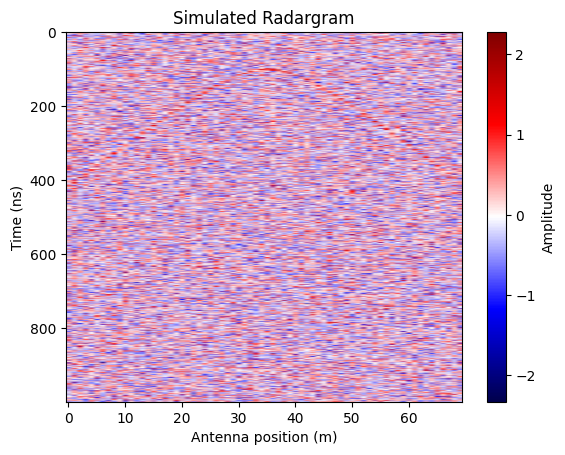

In [23]:
# Parameters
eps_r = 3                  # relative dielectric permittivity
rf = 400e6                 # radar frequency different from pulse frequency
dt = 1e-9                  # seconds
dx = 1                     # meters
region_shape = (70, 1e-6)  # grid (x,z)
SNR = 0.01
wavetype = 'gaussian'

# Point reflectors at (x,t) where x [m] and t [s]
reflectors = [(35, 50e-9)]

data, x_positions, t_samples = gprsim.gprsim(eps_r, rf, dt, dx, reflectors, region_shape, wavetype, SNR)

plt.imshow(data, aspect='auto', cmap='seismic')
plt.xlabel("Antenna position (m)")
plt.ylabel("Time (ns)")
plt.title("Simulated Radargram")
plt.colorbar(label="Amplitude")
plt.show()

(Text(0.5, 235.72222222222223, 'x distance (m)'),
 Text(50.222222222222214, 0.5, 't (ns)'))

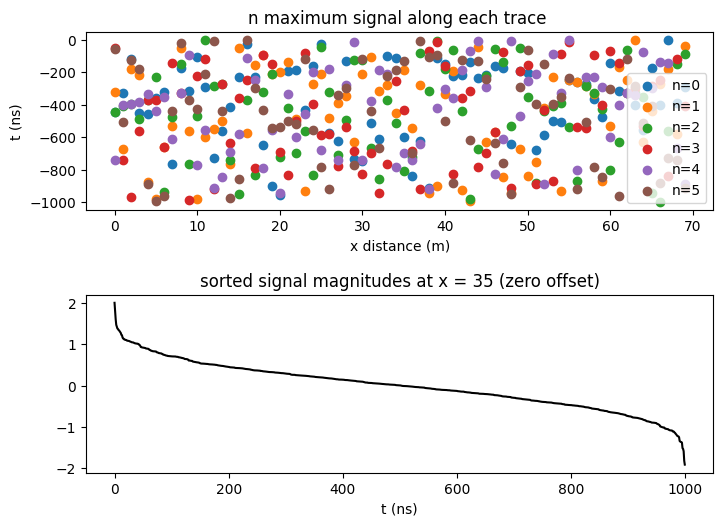

In [7]:
fig, ax = plt.subplots(2, figsize = (7,5))
fig.tight_layout(h_pad=4)

for n in range(0,6):
    t = data.argsort(axis=0)[::-1,:][n]* -1 # Ttake the indices of the max 5 signals
    x = np.arange(0, data.shape[1]) * dx # 
    ax[0].scatter(x, t, label=f"n={n}")

sample_signal = data[:,35]
ax[1].plot(np.sort(sample_signal)[::-1], c='black')
ax[1].set_title("sorted signal magnitudes at x = 35 (zero offset)")
ax[1].set_xlabel("t (ns)")
ax[0].legend()
ax[0].set_title("n maximum signal along each trace ")
ax[0].set_xlabel("x distance (m)"), ax[0].set_ylabel("t (ns)")

# The idea is that if we take n maximums, even with super noisy data we will have sufficient data to get the hyperbola

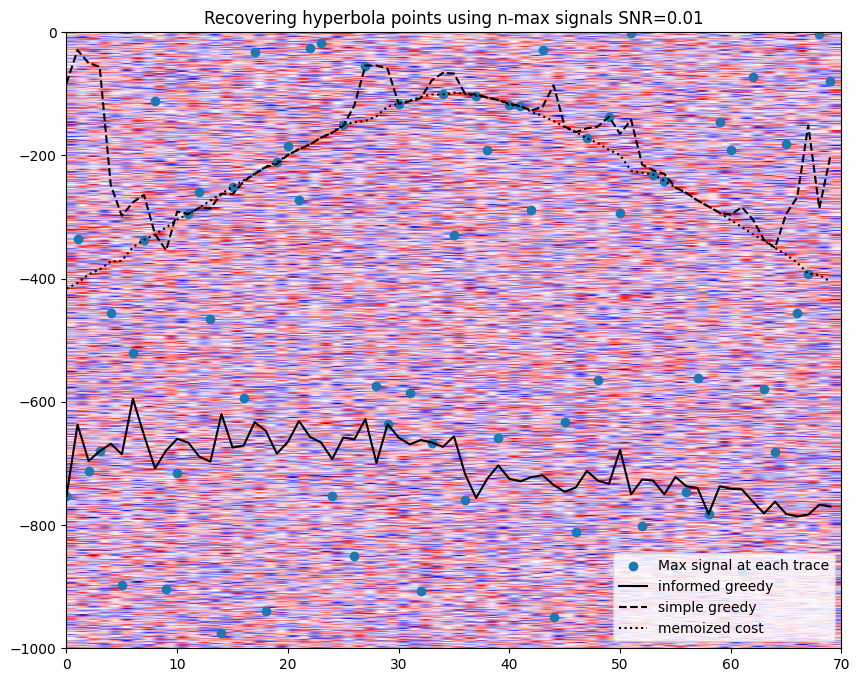

In [27]:
def minimize_tracewise_slope_greedy(data, n_candidates):
    t = data.argsort(axis=0)[::-1,:][0]
    t_og = data.argsort(axis=0)[::-1,:][0]* -1
    x = np.arange(0, data.shape[1]) * dx # 
    t_nmax = data.argsort(axis=0)[::-1,:] * -1

    candidates = np.array([data.argsort(axis=0)[::-1,:][n] for n in range(0,n_candidates)])
    for i in range(0,len(x)): # go through each trace
        candidate_indices = candidates[:, i]
        min_slope = math.inf
        slopes = []
        for cand in candidate_indices:
            slope = np.abs((cand-t[i-1])/(x[i]-x[i-1])) # calcuate the slope for each candidate index
            slopes.append(slope)
            if slope < min_slope: # If the slope suddenly becomes eggerdious
                t[i]=cand
                min_slope = slope
    return x, t

def minimize_tracewise_slope_window(data, n_candidates, dx, window):
    n_traces = data.shape[1]
    x = np.arange(n_traces) * dx
    
    # Precompute top-n candidate indices for each column
    candidates = data.argsort(axis=0)[::-1, :][:n_candidates, :]
    
    # Initialize with the top max of the first column
    t = np.zeros(n_traces, dtype=int)
    t[0] = candidates[0, 0]
    
    for i in range(1, n_traces):
        # Look back over a small window (min ensures bounds)
        start = max(0, i - window)
        prev_t = np.mean(t[start:i])  # local average trend
        
        candidate_indices = candidates[:, i]
        # Compute slope relative to local mean
        slopes = np.abs((candidate_indices - prev_t) / dx)
        # Choose the one that gives the smallest slope
        t[i] = candidate_indices[np.argmin(slopes)]
    
    return x, t

def smooth_path_dp(data, lam):
    nt, nx = data.shape
    C = np.zeros_like(data)
    backtrack = np.zeros_like(data, dtype=int)

    # Initialize first column
    C[:, 0] = data[:, 0]

    # DP forward pass, populate the memoized cost (C) and store the best path so far. This can be improved from n^2 but I thnk it's alright for now
    for x in range(1, nx):
        for t in range(nt):
            # Compute smoothness penalty relative to previous column, slope cost may not be needed
            penalties = C[:, x-1] - lam * (np.arange(nt) - t)**2
            best_prev = np.argmax(penalties)
            C[t, x] = data[t, x] + penalties[best_prev]
            backtrack[t, x] = best_prev

    # Backtrack the best path
    path = np.zeros(nx, dtype=int)
    path[-1] = np.argmax(C[:, -1])
    for x in range(nx-2, -1, -1):
        path[x] = backtrack[path[x+1], x+1]

    return np.arange(0, nx), -path


t, x = data.argsort(axis=0)[::-1,:][0], np.arange(0, data.shape[1]) * dx 
x_window, t_window = minimize_tracewise_slope_window(data, 20, 1, 5)
x_greedy, t_greedy = minimize_tracewise_slope_greedy(data, 15)
x_dynamic, t_dynamic = smooth_path_dp(data, lam=0.001)

fig = plt.figure(figsize=(10,8))
plt.title(f"Recovering hyperbola points using n-max signals SNR={SNR}")
plt.imshow(data, aspect='auto', extent=[0,70,-1000,0], cmap='seismic')
plt.scatter(x, -t, label="Max signal at each trace")
plt.plot(x_window, -t_window, label="informed greedy", c='black', linestyle='-')
plt.plot(x_greedy, -t_greedy, label="simple greedy", c='black', linestyle='--')
plt.plot(x_dynamic, t_dynamic, label="memoized cost", c='black', linestyle=':')
plt.legend(loc="lower right")

# Now that we've recovered a decent path, just do pinv fit

In [ ]:
def get_hyp_params(data):
    x, t = smooth_path_dp(data, lam=0.002) # 'clean' the input data to find good x, t(x) inputs to fit to

    # Our linearized form of the hyperbola equation
    A = np.column_stack([t**2, 2.0*x, -1.0*np.ones_like(x)])
    b = x**2
    
    # solve with pseudoinverse -- do this twice to reduce outliers
    consts = np.linalg.pinv(A) @ b
    r = A@consts - b  
    sigma = 1.5 * np.median(np.abs(r - np.median(r))) # scale mad
    
    mask = np.abs(r) <= 0.5 * sigma
    consts2 = np.linalg.pinv(A[mask]) @ b[mask]
    alpha, beta, gamma = consts2

    v = 2.0 * np.sqrt(alpha) * 1e9
    x0 = beta
    z = np.sqrt(gamma - x0**2)
    t0 = z/v
    print(f"v = {v:.1f} m/s, depth z = {z:.2f} m, apex x0 = {x0:.3f} m, t0 = {t0} s")
    
    return v, z, x0, t0

v, z, x0, t0 = get_hyp_params(data)

# This looks quite nice, Lets gradually degrade the SNR ot see how the alg responds

In [15]:
# Parameters
eps_r = 3                  # relative dielectric permittivity
rf = 400e6                 # radar frequency different from pulse frequency
dt = 1e-9                  # seconds
dx = 1                     # meters
region_shape = (70, 1e-6)  # grid (x,z)
wavetype = 'gaussian'
# Point reflectors at (x,t) where x [m] and t [s]
reflectors = [(35, 50e-9)]
x_0, t_0 = reflectors[0][0], reflectors[0][1]

drs = []
dx0s = []
dt0s = []
for SNR in [10, 1, 0.1, 0.05, 0.01, 0.008]:
    dr = np.zeros(5)
    dx0 = np.zeros(5)
    dt0 = np.zeros(5)
    for j in range(0,5):
        data, x_positions, t_samples = gprsim.gprsim(eps_r, rf, dt, dx, reflectors, region_shape, wavetype, SNR)
        v, z, x0, t0 = get_hyp_params(data)
        dr[j] = (np.abs(eps_r-(3e8/v)**2))
        dx0[j] = (np.abs(x_0-x0))
        dt0[j] = (np.abs(t_0-t0))
    drs.append(np.mean(dr))
    dx0s.append(np.mean(dx0))
    dt0s.append(np.mean(dt0))
        
        

v = 173260548.4 m/s, depth z = 8.67 m, apex x0 = 34.998 m, t0 = 5.004695283279937e-08 s
v = 173218426.7 m/s, depth z = 8.67 m, apex x0 = 35.000 m, t0 = 5.004209703458978e-08 s
v = 173245172.8 m/s, depth z = 8.67 m, apex x0 = 34.995 m, t0 = 5.004554022179982e-08 s
v = 173225451.0 m/s, depth z = 8.67 m, apex x0 = 34.997 m, t0 = 5.003696864923863e-08 s
v = 173251379.2 m/s, depth z = 8.68 m, apex x0 = 35.008 m, t0 = 5.0111514424897617e-08 s
v = 173172769.2 m/s, depth z = 8.66 m, apex x0 = 34.997 m, t0 = 4.9997658375987575e-08 s
v = 173229005.1 m/s, depth z = 8.67 m, apex x0 = 35.001 m, t0 = 5.002769394134011e-08 s
v = 173173975.2 m/s, depth z = 8.66 m, apex x0 = 35.003 m, t0 = 4.9992926369362705e-08 s
v = 173177656.6 m/s, depth z = 8.67 m, apex x0 = 34.995 m, t0 = 5.003599886745645e-08 s
v = 173228694.9 m/s, depth z = 8.66 m, apex x0 = 34.996 m, t0 = 4.999183245933064e-08 s
v = 173198110.4 m/s, depth z = 8.66 m, apex x0 = 34.966 m, t0 = 4.998310460657841e-08 s
v = 173136898.8 m/s, depth z 

/var/folders/vv/wqjks1114hz5w6vtzybkd8gc0000gn/T/ipykernel_71117/2963054928.py:19: RuntimeWarning: invalid value encountered in sqrt
  z = np.sqrt(gamma - x0**2)


v = 231946574.3 m/s, depth z = nan m, apex x0 = 22.791 m, t0 = nan s
v = 201379799.5 m/s, depth z = 9.83 m, apex x0 = 37.908 m, t0 = 4.883197827503882e-08 s


<BarContainer object of 6 artists>

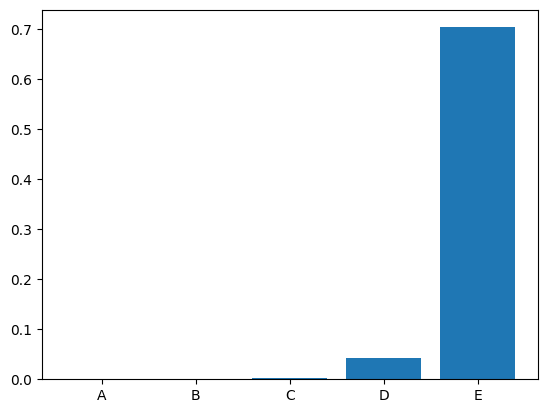

In [31]:
x = ["A", "B", "B", "C", "D", "E"]
plt.bar(x, drs)

v = 173221252.0 m/s, depth z = 8.67 m, apex x0 = 35.000 m, t0 = 5.005106153627434e-08 s
v = 173221252.0 m/s, depth z = 8.67 m, apex x0 = 35.000 m, t0 = 5.005106153627434e-08 s
v = 197929786.9 m/s, depth z = 9.62 m, apex x0 = 31.247 m, t0 = 4.8590117566935524e-08 s
v = 197929786.9 m/s, depth z = 9.62 m, apex x0 = 31.247 m, t0 = 4.8590117566935524e-08 s


(-1000.0, 0.0)

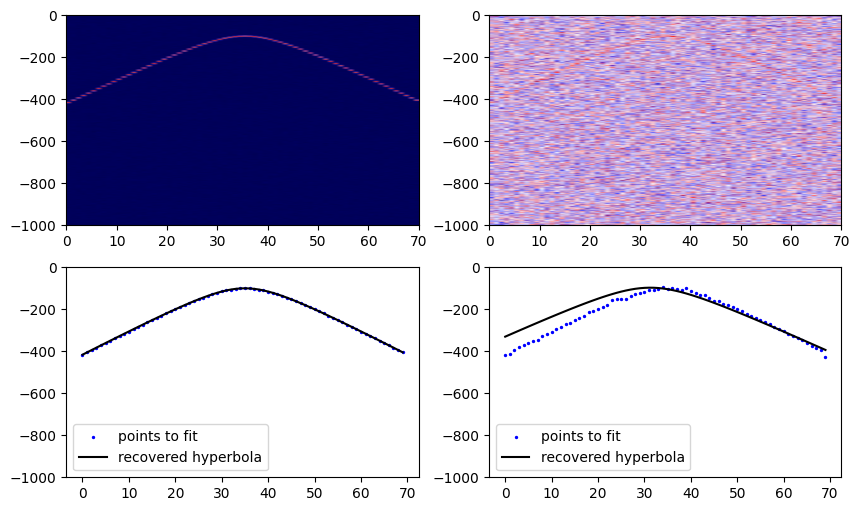

In [57]:
fig, axs = plt.subplots(2, 2, figsize=(10,6))
plt.gca()

eps_r = 3                  # relative dielectric permittivity
rf = 400e6                 # radar frequency different from pulse frequency
dt = 1e-9                  # seconds
dx = 1                     # meters
region_shape = (70, 1e-6)  # grid (x,z)
wavetype = 'gaussian'
reflectors = [(35, 50e-9)]
SNR = 100
x_0, t_0 = reflectors[0][0], reflectors[0][1]

data, x_positions, t_samples = gprsim.gprsim(eps_r, rf, dt, dx, reflectors, region_shape, wavetype, SNR)
axs[0][0].imshow(data, aspect='auto', extent=[0,70,-1000,0], cmap='seismic')
v, z, x0, t0 = get_hyp_params(data)
x_dynamic, t_dynamic = smooth_path_dp(data, lam=0.001)
axs[1][0].scatter(x_dynamic, t_dynamic, label="points to fit", s=2, c='blue')
v, z, x0, t0 = get_hyp_params(data)
x = np.arange(0, region_shape[0], dx)
axs[1][0].plot(x, -(2/v)*np.sqrt(z**2 + (x-x0)**2)*1e9, label='recovered hyperbola', c='black')
axs[1][0].legend()
axs[1][0].set_ylim(-1000,0)


eps_r = 3                  # relative dielectric permittivity
rf = 400e6                 # radar frequency different from pulse frequency
dt = 1e-9                  # seconds
dx = 1                     # meters
region_shape = (70, 1e-6)  # grid (x,z)
wavetype = 'gaussian'
reflectors = [(35, 50e-9)]
SNR = 0.009
x_0, t_0 = reflectors[0][0], reflectors[0][1]

data, x_positions, t_samples = gprsim.gprsim(eps_r, rf, dt, dx, reflectors, region_shape, wavetype, SNR)
axs[0][1].imshow(data, aspect='auto', extent=[0,70,-1000,0], cmap='seismic')
v, z, x0, t0 = get_hyp_params(data)
x_dynamic, t_dynamic = smooth_path_dp(data, lam=0.001)
axs[1][1].scatter(x_dynamic, t_dynamic, label="points to fit", s=2, c='blue')
v, z, x0, t0 = get_hyp_params(data)
x = np.arange(0, region_shape[0], dx)
axs[1][1].plot(x, -(2/v)*np.sqrt(z**2 + (x-x0)**2)*1e9, label='recovered hyperbola', c='black')
axs[1][1].legend()
axs[1][1].set_ylim(-1000,0)